Tried to find a match between true and predicted clusters

In [1]:
from sklearn.metrics import normalized_mutual_info_score, accuracy_score, precision_score, recall_score
import numpy as np
import torch
import pandas as pd
import ast
import matplotlib.pyplot as plt
import os
import re

In [2]:
purity = 1.0
coverage = 100
general_folder = f"./results/p_{str(purity).replace('.', '')}_cov_{coverage}/"

In [3]:
def compute_pairwise_nmi(true_labels, predicted_labels, threshold=0.5):
    unique_true = np.unique(np.array(true_labels, dtype = 'int'))
    unique_pred = np.unique(predicted_labels)
    # Initialize mapping and NMI matrix
    nmi_matrix = np.zeros((len(unique_true), len(unique_pred)))
    label_mapping = {}
    
    # Construct pairwise NMI matrix
    # Rows: true labels, Columns: predicted labels
    for i, true_label in enumerate(unique_true):
        for j, pred_label in enumerate(unique_pred):
            true_mask = (true_labels == true_label).astype(int)
            pred_mask = (predicted_labels == pred_label).astype(int)
            
            nmi_matrix[i, j] = normalized_mutual_info_score(true_mask, pred_mask)
    
    # Select the best matching predicted label for each true label
    for i, true_label in enumerate(unique_true):
        best_pred_index = np.argmax(nmi_matrix[i, :])  # Index of the best match (i.e. column)
        best_nmi = nmi_matrix[i, best_pred_index]

        if best_nmi >= threshold:
            label_mapping[true_label] = unique_pred[best_pred_index]

    return label_mapping, nmi_matrix  

In [4]:
import re
def retrieve_param(df, 
                   true_labels,
                    pred_labels,
                    true_labels_clusters, 
                    pred_labels_clusters,
                    true_phi_list,
                    true_kappa_list,
                    true_alpha_list, 
                    pred_phi_list, 
                    pred_kappa_list,
                    pred_alpha_list):
    
    true_alpha_df = df['True_alpha']
    pred_alpha_df = df['Pred_alpha']
    true_phi_df = df['True_phi']
    pred_phi_df = df['Pred_phi']
    true_kappa_df = df['True_kappa']
    pred_kappa_df = df['Pred_kappa']

    true_dist = df['True_distribution'].apply(ast.literal_eval)
    true_dist = torch.tensor(true_dist, dtype=torch.float32)
    pred_dist = df['Pred_distribution'].apply(ast.literal_eval)
    pred_dist = torch.tensor(pred_dist, dtype=torch.float32)

    pattern = r"\[(.*),(.*)\]"
    true_alpha = torch.zeros((len(true_alpha_df), 2))
    # print(true_alpha.shape)
    for i, string in enumerate(true_alpha_df):
        a = float(re.findall(pattern , string)[0][0])
        b = float(re.findall(pattern , string)[0][1])
        true_alpha[i,:] = torch.tensor([a,b])

    true_phi = torch.zeros((len(true_phi_df), 2))
    for i, string in enumerate(true_phi_df):
        a = float(re.findall(pattern, string)[0][0])
        b = float(re.findall(pattern, string)[0][1])
        true_phi[i,:] = torch.tensor([a,b])

    true_kappa = torch.zeros((len(true_kappa_df), 2))
    for i, string in enumerate(true_kappa_df):
        a = float(re.findall(pattern , string)[0][0])
        b = float(re.findall(pattern , string)[0][1])
        true_kappa[i,:] = torch.tensor([a,b])

    pattern = r"\[(.*),(.*)\]"
    pred_alpha = torch.zeros((len(pred_alpha_df), 2))
    # print(true_alpha.shape)
    for i, string in enumerate(pred_alpha_df):
        a = float(re.findall(pattern , string)[0][0])
        b = float(re.findall(pattern , string)[0][1])
        pred_alpha[i,:] = torch.tensor([a,b])

    pred_phi = torch.zeros((len(pred_phi_df), 2))
    for i, string in enumerate(pred_phi_df):
        a = float(re.findall(pattern, string)[0][0])
        b = float(re.findall(pattern, string)[0][1])
        pred_phi[i,:] = torch.tensor([a,b])

    pred_kappa = torch.zeros((len(pred_kappa_df), 2))
    for i, string in enumerate(pred_kappa_df):
        a = float(re.findall(pattern , string)[0][0])
        b = float(re.findall(pattern , string)[0][1])
        pred_kappa[i,:] = torch.tensor([a,b])
    
    first_occurrence_indices_true = torch.zeros_like(true_labels_clusters, dtype=torch.long)
    for i, val in enumerate(true_labels_clusters):
        first_occurrence_indices_true[i] = (true_labels == val).nonzero(as_tuple=True)[0][0]
    true_dist_cluster = true_dist[first_occurrence_indices_true]
    
    first_occurrence_indices_pred = torch.zeros_like(pred_labels_clusters, dtype=torch.long)
    for i, val in enumerate(pred_labels_clusters):
        first_occurrence_indices_pred[i] = (pred_labels == val).nonzero(as_tuple=True)[0][0]
    pred_dist_cluster = pred_dist[first_occurrence_indices_pred]

    pred_alpha_cluster = pred_alpha[first_occurrence_indices_pred]
    true_alpha_cluster = true_alpha[first_occurrence_indices_true]

    pred_phi_cluster = pred_phi[first_occurrence_indices_pred]
    true_phi_cluster = true_phi[first_occurrence_indices_true]

    pred_kappa_cluster = pred_kappa[first_occurrence_indices_pred]
    true_kappa_cluster = true_kappa[first_occurrence_indices_true]

    # print(true_dist_cluster)
    for k in range(len(true_dist_cluster)):
        for d in range(2):
            if true_dist_cluster[k,d] == 0 and pred_dist_cluster[k,d] == 0: #pareto
                # qui si può anche aggiungere conteggio di quante ne fa giuste
                true_alpha_list.append(true_alpha_cluster[k][d])
                pred_alpha_list.append(pred_alpha_cluster[k][d])
            elif true_dist_cluster[k,d] == 1 and pred_dist_cluster[k,d] == 1:
                if ((true_phi_cluster[k][d] < 0.22) and (pred_phi_cluster[k][d] > 0.44)):
                    print(k,d)
                true_phi_list.append(true_phi_cluster[k][d])
                true_kappa_list.append(true_kappa_cluster[k][d])
                pred_phi_list.append(pred_phi_cluster[k][d])
                pred_kappa_list.append(pred_kappa_cluster[k][d])
    return true_dist_cluster, pred_dist_cluster

In [4]:
def compute_metrics(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels, pred_labels)
    precision_class_0 = precision_score(true_labels, pred_labels, pos_label=0)
    precision_class_1 = precision_score(true_labels, pred_labels, pos_label=1)
    recall_class_0 = recall_score(true_labels, pred_labels, pos_label=0)
    recall_class_1 = recall_score(true_labels, pred_labels, pos_label=1)

    return [accuracy, precision_class_0, precision_class_1, recall_class_0, recall_class_1]


# Directory containing the CSV files

true_phi_list = []
true_kappa_list = []
true_alpha_list = []

pred_phi_list = []
pred_kappa_list = []
pred_alpha_list = []

# Regular expression pattern to match the file names and extract N, K, D, and df values
pattern = re.compile(r'N_(\d+)_K_(\d+)_D_(\d+)_df_(\d+)\.csv')
cluster_dist_total = []

N_values = [5000, 10000, 15000]
K_values = [3, 5, 8]
D_values = [2,3,4]

# Placeholder for metrics for all combinations of N and K
metrics_data = {f"N_{N}_K_{K}_D_{D}": [] for N in N_values for K in K_values for D in D_values}
for dim in D_values:
    directory = general_folder + f"D_{dim}/csv"
    for filename in os.listdir(directory):
        # Check if the file matches the pattern
        match = pattern.match(filename)
        if match:
            # Extract N, K, D, and df values from the file name
            N, K, D, df = map(int, match.groups())
            print('N ', N, 'K ', K, 'D ', D, 'idx ',df)
            file_path = os.path.join(directory, filename)
            df_data = pd.read_csv(file_path)
            
            if 'True_cluster' in df_data.columns and 'Pred_cluster' in df_data.columns:
                true_labels = df_data['True_cluster'].tolist()
                pred_labels = df_data['Pred_cluster'].tolist()

                nmi_threshold = 0.3 # 0.4
                label_mapping, nmi_matrix = compute_pairwise_nmi(true_labels, pred_labels, threshold=nmi_threshold)
                # print(label_mapping)
                true_labels_match = list(label_mapping.keys())
                # print(true_labels_match)
                pred_labels_match = list(label_mapping.values())
                # print(pred_labels_match)

                # Extract true and predicted distributions from the csv
                true_dist = df_data['True_distribution'].apply(ast.literal_eval)
                true_dist = torch.tensor(true_dist, dtype=torch.int)
                pred_dist = df_data['Pred_distribution'].apply(ast.literal_eval)
                pred_dist = torch.tensor(pred_dist, dtype=torch.int)
                
                first_occurrence_indices_true = [true_labels.index(label) for label in true_labels_match]
                # print(first_occurrence_indices_true)
                true_dist_match = true_dist[first_occurrence_indices_true]
                # print(true_dist_cluster)
                
                first_occurrence_indices_pred = [pred_labels.index(label) for label in pred_labels_match]
                # print(first_occurrence_indices_pred)
                pred_dist_match = pred_dist[first_occurrence_indices_pred]
                # print(pred_dist_cluster)

                # Flatten the arrays
                true_dist_match = true_dist_match.ravel()
                pred_dist_match = pred_dist_match.ravel()
                accuracy = accuracy_score(true_dist_match, pred_dist_match)
                metrics_data[f"N_{N}_K_{K}_D_{D}"].append(accuracy)
# metrics_data

N  5000 K  3 D  2 idx  8
N  15000 K  8 D  2 idx  0
N  5000 K  5 D  2 idx  11
N  10000 K  8 D  2 idx  13
N  15000 K  5 D  2 idx  3
N  10000 K  5 D  2 idx  13
N  10000 K  3 D  2 idx  3
N  5000 K  3 D  2 idx  12
N  5000 K  8 D  2 idx  4
N  10000 K  8 D  2 idx  8
N  10000 K  8 D  2 idx  5
N  15000 K  8 D  2 idx  14
N  5000 K  8 D  2 idx  13
N  15000 K  5 D  2 idx  7
N  15000 K  3 D  2 idx  7
N  15000 K  5 D  2 idx  1
N  15000 K  3 D  2 idx  0
N  15000 K  5 D  2 idx  6
N  10000 K  3 D  2 idx  14
N  10000 K  8 D  2 idx  6
N  15000 K  8 D  2 idx  12
N  5000 K  5 D  2 idx  0
N  5000 K  8 D  2 idx  9
N  5000 K  3 D  2 idx  11
N  15000 K  5 D  2 idx  14
N  10000 K  3 D  2 idx  11
N  5000 K  3 D  2 idx  4
N  5000 K  3 D  2 idx  3
N  5000 K  8 D  2 idx  12
N  10000 K  5 D  2 idx  5
N  10000 K  5 D  2 idx  6
N  5000 K  3 D  2 idx  2
N  15000 K  5 D  2 idx  8
N  5000 K  8 D  2 idx  11
N  15000 K  8 D  2 idx  10
N  15000 K  3 D  2 idx  1
N  10000 K  8 D  2 idx  12
N  15000 K  8 D  2 idx  5
N  10000 K

OSError: [Errno 6] Device not configured

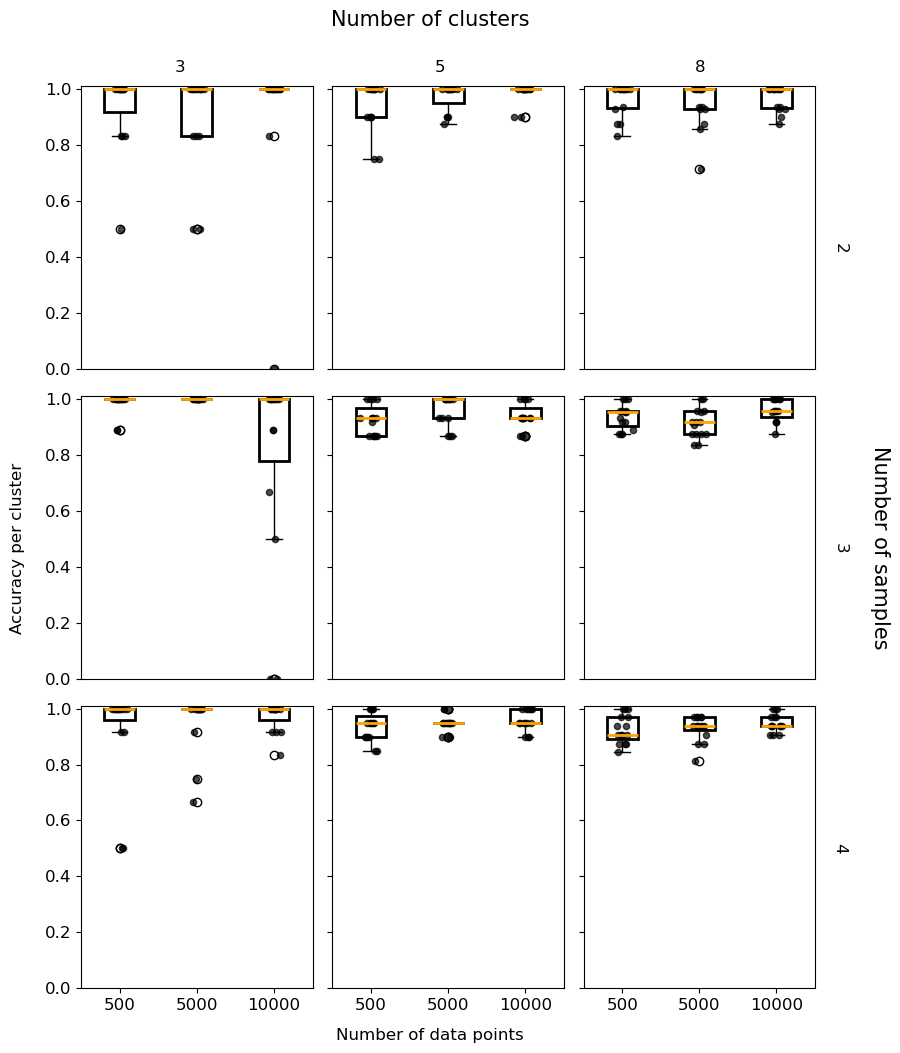

In [16]:
# PLOT PER NUMBER OF DATA POINTS
N_values = [5000, 10000, 15000]
K_values = [3, 5, 8]
D_values = [2, 3, 4]

fig, axes = plt.subplots(len(N_values), len(K_values), figsize=(10, 12), sharey=True)

for i, D in enumerate(D_values):
    for j, K in enumerate(K_values):
        ax = axes[i, j]

        all_metrics = []
        for N in N_values:
            metrics_key = f"N_{N}_K_{K}_D_{D}"
            metrics = np.array(metrics_data.get(metrics_key, []))  # Replace with your data retrieval logic
            all_metrics.append(metrics)

        if any(metrics.size > 0 for metrics in all_metrics):
            # Boxplot for all D values
            positions = np.arange(1, len(D_values) + 1)
            box = ax.boxplot(all_metrics, positions=positions, notch=False, patch_artist=True, widths=0.4)

            for patch in box['boxes']:
                patch.set_facecolor((0, 0, 0, 0))
                patch.set_edgecolor('black')     
                patch.set_linewidth(2)

            for median in box['medians']:
                median.set_color('orange')
                median.set_linewidth(2)

            # Add scatter points for individual data points
            for k, (metrics, pos) in enumerate(zip(all_metrics, positions)):
                jitter = np.random.normal(0, 0.05, size=len(metrics))  # Add jitter to avoid overlap
                ax.scatter(np.full(len(metrics), pos) + jitter, metrics, alpha=0.7, color='black', s=20)

            # Set x-ticks for D values
            if i == len(D_values) - 1:  # Only for the bottom row
                ax.set_xticks(positions)
                ax.set_xticklabels([str(N) for N in N_values], fontsize=12)
            else:
                ax.set_xticks([])

            ax.set_ylim([0.0, 1.01])  # Adjust y-axis limits
        else:
            ax.set_xticks([])

        ax.tick_params(axis='y', labelsize=12)

for j, K in enumerate(K_values):
    fig.text(0.25 + j * 0.26, 0.90, f'{K}', va='center', ha='center', fontsize=12)

fig.text(0.5, 0.94, 'Number of clusters', va='center', ha='center', fontsize=15)

fig.text(0.95, 0.5, 'Number of samples', va='center', ha='center', rotation=-90, fontsize=15)
for i, D in enumerate(D_values):
    fig.text(0.91, 0.75 - i * 0.25, f'{D}', va='center', ha='center', rotation=-90, fontsize=12)

fig.text(0.08, 0.5, 'Accuracy per cluster', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.09, 'Number of data points', ha='center', fontsize=12)
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
plt.show()


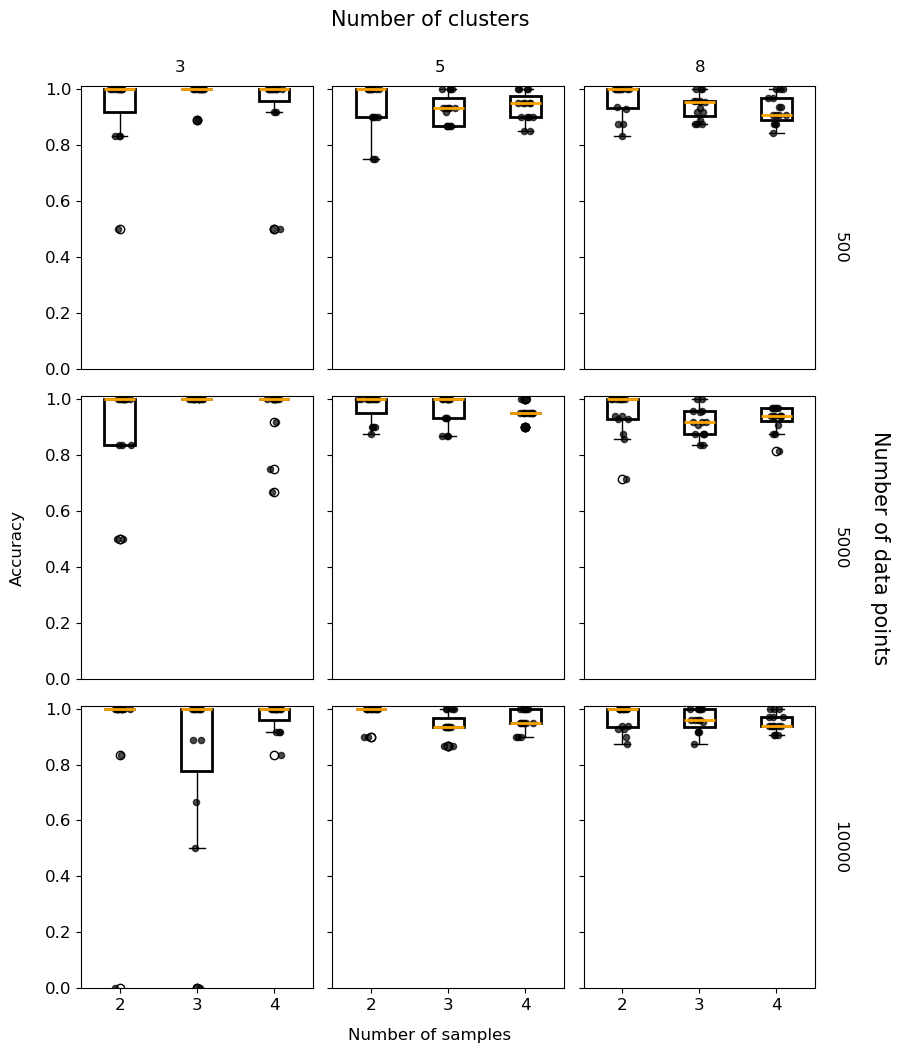

In [11]:
N_values = [5000, 10000, 15000]
K_values = [3, 5, 8]
D_values = [2, 3, 4]

fig, axes = plt.subplots(len(N_values), len(K_values), figsize=(10, 12), sharey=True)

for i, N in enumerate(N_values):
    for j, K in enumerate(K_values):
        ax = axes[i, j]

        all_metrics = []
        for D in D_values:
            metrics_key = f"N_{N}_K_{K}_D_{D}"
            metrics = np.array(metrics_data.get(metrics_key, []))  # Replace with your data retrieval logic
            all_metrics.append(metrics)

        if any(metrics.size > 0 for metrics in all_metrics):
            # Boxplot for all D values
            positions = np.arange(1, len(D_values) + 1)
            box = ax.boxplot(all_metrics, positions=positions, notch=False, patch_artist=True, widths=0.4)

            for patch in box['boxes']:
                patch.set_facecolor((0, 0, 0, 0))
                patch.set_edgecolor('black')     
                patch.set_linewidth(2)

            for median in box['medians']:
                median.set_color('orange')
                median.set_linewidth(2)

            # Add scatter points for individual data points
            for k, (metrics, pos) in enumerate(zip(all_metrics, positions)):
                jitter = np.random.normal(0, 0.05, size=len(metrics))  # Add jitter to avoid overlap
                ax.scatter(np.full(len(metrics), pos) + jitter, metrics, alpha=0.7, color='black', s=20)

            # Set x-ticks for D values
            if i == len(N_values) - 1:  # Only for the bottom row
                ax.set_xticks(positions)
                ax.set_xticklabels([str(D) for D in D_values], fontsize=12)
            else:
                ax.set_xticks([])

            ax.set_ylim([0.0, 1.01])  # Adjust y-axis limits
        else:
            ax.set_xticks([])

        ax.tick_params(axis='y', labelsize=12)

for j, K in enumerate(K_values):
    fig.text(0.25 + j * 0.26, 0.90, f'{K}', va='center', ha='center', fontsize=12)

fig.text(0.5, 0.94, 'Number of clusters', va='center', ha='center', fontsize=15)

fig.text(0.95, 0.5, 'Number of data points', va='center', ha='center', rotation=-90, fontsize=15)
for i, N in enumerate(N_values):
    fig.text(0.91, 0.75 - i * 0.25, f'{N}', va='center', ha='center', rotation=-90, fontsize=12)

fig.text(0.08, 0.5, 'Accuracy per cluster', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.09, 'Number of samples', ha='center', fontsize=12)
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
plt.show()


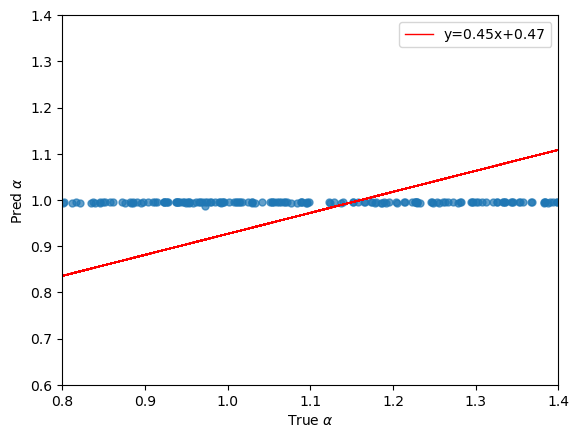

In [18]:
import matplotlib.pyplot as plt
plt.scatter(true_alpha_list, torch.tensor(pred_alpha_list),alpha = 0.7, s = 25)

slope, intercept = np.polyfit(true_alpha_list, pred_alpha_list, 1)

regression_line = [slope * x + intercept for x in true_alpha_list]
plt.plot(true_alpha_list, regression_line, color='red', linewidth = 1,label=f'y={slope:.2f}x+{intercept:.2f}')

plt.xlabel('True $\\alpha$')
plt.ylabel('Pred $\\alpha$')
plt.xlim([0.8, 1.4])
plt.ylim([0.6, 1.4])
plt.legend()
plt.show()

/var/folders/z4/6ll9fb5s3k52m037sj27846c0000gn/T/ipykernel_1699/870058352.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


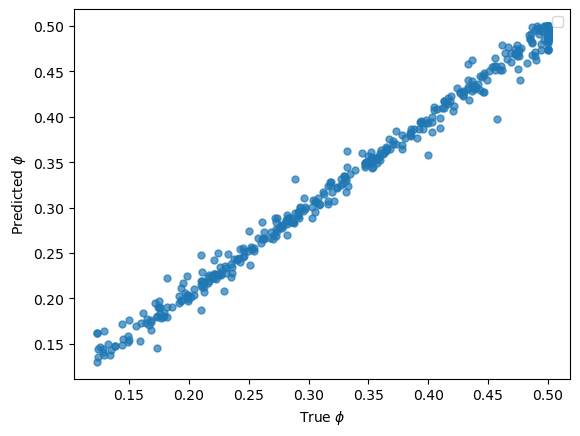

In [20]:
import matplotlib.pyplot as plt
plt.scatter(true_phi_list, pred_phi_list, alpha = 0.7, s = 25)
slope, intercept = np.polyfit(true_phi_list, pred_phi_list, 1)

regression_line = [slope * x + intercept for x in true_phi_list]

# plt.plot(true_phi_list, regression_line, color='red', linewidth = 1,label=f'y={slope:.2f}x+{intercept:.2f}')

plt.xlabel(f'True $\\phi$')
plt.ylabel('Predicted $\\phi$')
plt.legend()
# plt.xlim([0.8, 1.6])
# plt.ylim([0.8, 1.6])
plt.show()

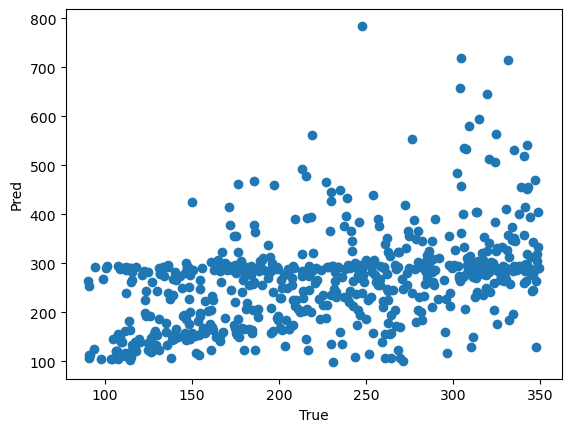

In [22]:
import matplotlib.pyplot as plt
plt.scatter(true_kappa_list, pred_kappa_list)

plt.xlabel('True')
plt.ylabel('Pred')
# plt.xlim([100, 400])
# plt.ylim([100, 400])
plt.show()

### Boxplots accuracy per data point

In [4]:
# Regular expression pattern to match the file names and extract N, K, D, and df values
pattern = re.compile(r'N_(\d+)_K_(\d+)_D_(\d+)_df_(\d+)\.csv')
cluster_dist_total = []

N_values = [5000, 10000, 15000]
K_values = [3, 5, 8]
D_values = [2,3,4]

# Placeholder for metrics for all combinations of N and K
metrics_data_points = {f"N_{N}_K_{K}_D_{D}": [] for N in N_values for K in K_values for D in D_values}
for dim in D_values:
    directory = general_folder + f"D_{dim}/csv"
    for filename in os.listdir(directory):
        # Check if the file matches the pattern
        match = pattern.match(filename)
        if match:
            # Extract N, K, D, and df values from the file name
            N, K, D, df = map(int, match.groups())
            print('N ', N, 'K ', K, 'D ', D, 'idx ',df)
            file_path = os.path.join(directory, filename)
            df_data = pd.read_csv(file_path)
            
            if 'True_cluster' in df_data.columns and 'Pred_cluster' in df_data.columns:
                true_dist = np.array([ast.literal_eval(item) for item in df_data['True_distribution']])
                pred_dist = np.array([ast.literal_eval(item) for item in df_data['Pred_distribution']])
                
                # Calculate accuracy for both dimensions
                true_dist = true_dist.ravel()
                pred_dist = pred_dist.ravel()
                accuracy_data_points = accuracy_score(true_dist, pred_dist)
                # accuracy_data_points = np.mean(true_dist[:, 0] == pred_dist[:, 0])

                metrics_data_points[f"N_{N}_K_{K}_D_{D}"].append(accuracy_data_points)
# metrics_data

N  500 K  8 D  2 idx  5
N  5000 K  3 D  2 idx  8
N  500 K  8 D  2 idx  9
N  5000 K  5 D  2 idx  11
N  500 K  8 D  2 idx  8
N  500 K  3 D  2 idx  1
N  10000 K  8 D  2 idx  13
N  500 K  3 D  2 idx  4
N  10000 K  5 D  2 idx  13
N  10000 K  3 D  2 idx  3
N  500 K  5 D  2 idx  3
N  500 K  5 D  2 idx  9
N  500 K  3 D  2 idx  10
N  500 K  3 D  2 idx  6
N  5000 K  3 D  2 idx  12
N  5000 K  8 D  2 idx  4
N  10000 K  8 D  2 idx  8
N  10000 K  8 D  2 idx  5
N  5000 K  8 D  2 idx  13
N  500 K  8 D  2 idx  0
N  500 K  3 D  2 idx  7
N  10000 K  3 D  2 idx  14
N  500 K  3 D  2 idx  5
N  10000 K  8 D  2 idx  6
N  500 K  5 D  2 idx  1
N  5000 K  5 D  2 idx  0
N  500 K  8 D  2 idx  13
N  500 K  3 D  2 idx  8
N  5000 K  8 D  2 idx  9
N  5000 K  3 D  2 idx  11
N  500 K  5 D  2 idx  4
N  10000 K  3 D  2 idx  11
N  5000 K  3 D  2 idx  4
N  5000 K  3 D  2 idx  3
N  500 K  3 D  2 idx  13
N  5000 K  8 D  2 idx  12
N  10000 K  5 D  2 idx  5
N  10000 K  5 D  2 idx  6
N  5000 K  3 D  2 idx  2
N  500 K  5 D  2 idx

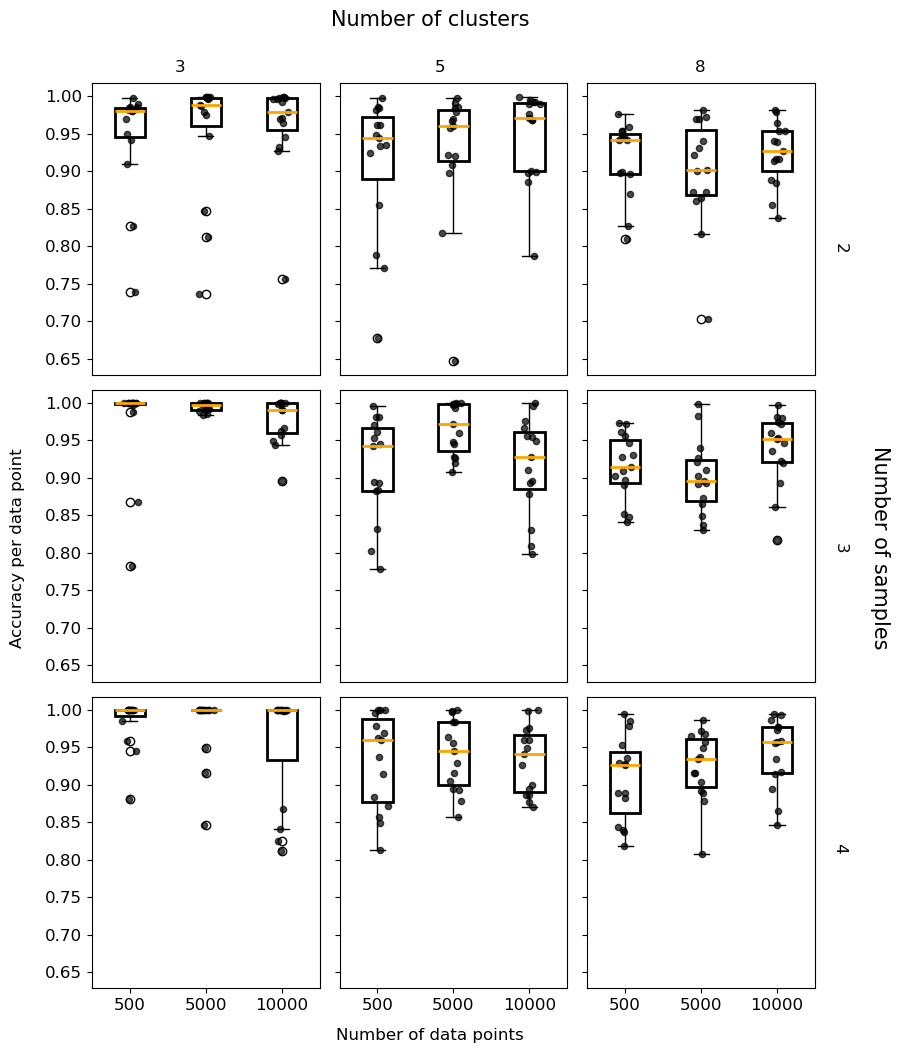

In [9]:
# PLOT PER NUMBER OF DATA POINTS
N_values = [5000, 10000, 15000]
K_values = [3, 5, 8]
D_values = [2, 3, 4]

fig, axes = plt.subplots(len(N_values), len(K_values), figsize=(10, 12), sharey=True)

for i, D in enumerate(D_values):
    for j, K in enumerate(K_values):
        ax = axes[i, j]

        all_metrics = []
        for N in N_values:
            metrics_key = f"N_{N}_K_{K}_D_{D}"
            metrics = np.array(metrics_data_points.get(metrics_key, []))  # Replace with your data retrieval logic
            all_metrics.append(metrics)

        if any(metrics.size > 0 for metrics in all_metrics):
            # Boxplot for all D values
            positions = np.arange(1, len(D_values) + 1)
            box = ax.boxplot(all_metrics, positions=positions, notch=False, patch_artist=True, widths=0.4)

            for patch in box['boxes']:
                patch.set_facecolor((0, 0, 0, 0))
                patch.set_edgecolor('black')     
                patch.set_linewidth(2)

            for median in box['medians']:
                median.set_color('orange')
                median.set_linewidth(2)

            # Add scatter points for individual data points
            for k, (metrics, pos) in enumerate(zip(all_metrics, positions)):
                jitter = np.random.normal(0, 0.05, size=len(metrics))  # Add jitter to avoid overlap
                ax.scatter(np.full(len(metrics), pos) + jitter, metrics, alpha=0.7, color='black', s=20)

            # Set x-ticks for D values
            if i == len(D_values) - 1:  # Only for the bottom row
                ax.set_xticks(positions)
                ax.set_xticklabels([str(N) for N in N_values], fontsize=12)
            else:
                ax.set_xticks([])

            # ax.set_ylim([0.0, 1.01])  # Adjust y-axis limits
        else:
            ax.set_xticks([])

        ax.tick_params(axis='y', labelsize=12)

for j, K in enumerate(K_values):
    fig.text(0.25 + j * 0.26, 0.90, f'{K}', va='center', ha='center', fontsize=12)

fig.text(0.5, 0.94, 'Number of clusters', va='center', ha='center', fontsize=15)

fig.text(0.95, 0.5, 'Number of samples', va='center', ha='center', rotation=-90, fontsize=15)
for i, D in enumerate(D_values):
    fig.text(0.91, 0.75 - i * 0.25, f'{D}', va='center', ha='center', rotation=-90, fontsize=12)

fig.text(0.08, 0.5, 'Accuracy per data point', va='center', rotation='vertical', fontsize=12)
fig.text(0.5, 0.09, 'Number of data points', ha='center', fontsize=12)
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.9])
plt.show()